In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib as mpl
from scipy import stats 
import math
import seaborn as sns

plt.rcParams.update({
    #"text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
#plt.rc('text.latex', preamble=r'\usepackage{color}')
smallfs = 8
bigfs = 10

plt.rcParams.update({'font.size': bigfs, 'axes.titlesize':bigfs})
plt.rc('axes', labelsize=bigfs)    # fontsize of the x and y labels
plt.rc('legend',fontsize=smallfs)
plt.rc('xtick', labelsize=smallfs)    # fontsize of the tick labels
plt.rc('ytick', labelsize=smallfs)    # fontsize of the tick labels



# Agent Success in sending a message
### ... with opinion distribution consisting of 2 Gaussians as in the calibrated initial conditions (Figure 3) 

In [2]:
from model import init2G
n = 1000
s = 2
np.random.seed(s)
ops2G = init2G(n)

nu = 0.13
bc = 0.175

successDown = np.zeros(len(ops2G))
successUp= np.zeros(len(ops2G))
unsuccesful = np.zeros(len(ops2G))

successDown0Amb = np.zeros(len(ops2G))
successUp0Amb= np.zeros(len(ops2G))
unsuccesful0Amb = np.zeros(len(ops2G))
    
    
impact = dict(zip(range(len(ops2G)), [[] for _ in range(len(ops2G))]))
for speaker in range(len(ops2G)):  # speaker
        for t in range(1000):
            listener, _ = np.random.choice(range(len(ops2G)), size=2, replace=False)
            while True:
                m = ops2G[speaker] + np.random.normal(0,nu)
                if (m <=1) and (m>=0):
                    break
            # selection
            if abs(ops2G[listener] - ops2G[speaker]) <= bc:
                if ops2G[speaker]<=ops2G[listener]:
                    successDown0Amb[speaker]+=1
                else:
                    successUp0Amb[speaker]+=1 
            else:                
                unsuccesful0Amb[speaker]+=1          

                
            if abs(ops2G[listener]-m) <= bc:
                impact[speaker].append((m-ops2G[listener]))
                if impact[speaker][-1]>0:
                    successUp[speaker]+=1
                else:
                    successDown[speaker]+=1  
                #opsPost[i].append(ops[i] + 0.5 * (mAmj - ops[i]))
            else:
                unsuccesful[speaker]+=1          
            #if abs(ops[j]-mAmi) <= bc:
            #    impact[i].append((mAmi - ops[j]))        
            #    if impact[i][-1]>0:
            #        successUp[i]+=1
            #    else:   
            #        successDown[i]+=1   
            #    opsPost[j].append(ops[j] + 0.5 * (mAmi - ops[j]))
            #else:
            #    unsuccesful[i]+=1     
            


In [15]:
# split by bins
bins = np.linspace(0,1,41)
binmids = bins[:-1]+ np.diff(bins)[0]/2

succ = []
unsucc = []
succ0Amb = []
unsucc0Amb = []
#I = []
for b0, b1 in zip(bins[:-1], bins[1:]):
    inds = np.where((ops2G>=b0) & (ops2G<b1))[0]
    if len(inds)>0:
        succ.append(np.mean([successDown[i]+successUp[i] for i in inds]))
        unsucc.append(np.mean([unsuccesful[i] for i in inds]))
        succ0Amb.append(np.mean([successDown0Amb[i] + successUp0Amb[i] for i in inds]))
        unsucc0Amb.append(np.mean([unsuccesful0Amb[i] for i in inds]))
        #I.append(np.mean([np.mean(impact[i]) for i in inds]))
    else:
        succ.append(0)
        unsucc.append(0)
        succ0Amb.append(0)
        unsucc0Amb.append(0)
        #I.append(0)

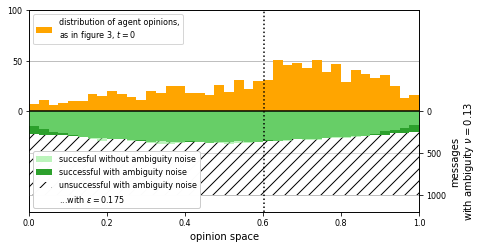

In [29]:

#succ = np.mean(succ_arr, axis=0)
#I = np.mean(I_arr, axis=0)
#unsucc = np.mean(unsucc_arr, axis=0)
#ops = np.concatenate(ops_arr)
succ = np.array(succ)
unsucc = np.array(unsucc)
succ0Amb = np.array(succ0Amb)

fig = plt.figure(figsize=(16/2.54,9/2.54))
ax = plt.axes()
aa, _ = np.histogram(ops2G, bins=bins)
ax.hist(ops2G, bins=bins, width=np.diff(bins)[0], label=r"distribution of agent opinions,"+"\n"+r"as in figure 3, $t=0$", color="orange")
ax.set_ylim(-max(aa)*1.4, max(aa)*1.4)
ax.legend(loc="upper left", fontsize=smallfs)
#ax.set_yticks([0, 10*len(ops), 20*len(ops) ])
ylim = 100
ax.set_yticks([0,int(ylim/2), ylim])
ax.set_yticklabels([int(u) for u in ax.get_yticks()])
ax.set_xlim(0,1)
ax.set_ylim(-ylim,ylim)
ax.grid(axis="y")
ax.set_axisbelow(True)


ax2 = ax.twinx()
a = ax2.bar(binmids, -succ, color="tab:green", width=np.diff(bins)[0], label=r"successful with ambiguity noise")
b = ax2.bar(binmids, -unsucc, bottom=-succ, color="white", hatch="//", alpha=0.3, edgecolor=None, width=np.diff(bins)[0], label=r"unsuccessful with ambiguity noise")#frequency of sending"+"\n"+r"an unsuccessful message")
d = ax2.bar(binmids, -succ0Amb, color="lightgreen", width=np.diff(bins)[0], label=r"succesful without ambiguity noise", alpha=0.6)

c, = ax2.plot([],[], lw=0, label=fr"...with $\epsilon={bc}$")
ax2.legend(handles=[d, a,b, c], loc="lower left", fontsize=smallfs, framealpha=0.99,)
ylim = max(succ+unsucc)
ax2.set_ylim(-ylim*1.2,ylim*1.2)
ax2.set_xlim(0,1)
ax2.set_yticks([-1000, -500, 0, ])
ax2.set_yticklabels([-int(l) for l in ax2.get_yticks()])
ax2.set_ylabel(r"messages"+"\n"+r"with ambiguity $\nu=0.13$", y=0.25)
ax2.grid(axis="y")
ax2.set_axisbelow(True)


ax.set_xlabel("opinion space", fontsize=bigfs)
ax2.vlines(np.mean(ops2G), -3000,3000, color="k", linestyles=":")
ax2.hlines(0, -3000,3000, color="k")

plt.subplots_adjust(left=0.04, top=0.99, bottom=0.2)
plt.savefig(f"figs/success-in-sending_seed{s}_2G-6AM.png", dpi=600)


### ... with opinion distribution consisting of 1 Gaussians (ESM-Figure S10)

In [16]:
n = 2000

s = 2
np.random.seed(s)

meanG = 0.6
sigG = 0.15
opsG = np.random.normal(meanG, sigG, size=int(n*1.2))
opsG = [o for o in opsG if 0<=o<=1][:n]  # take n samples that are within the bounds

nu = 0.13
bc = 0.175

successDownG = np.zeros(len(opsG)) # tracking successful messages with ambiguity noise
successUpG= np.zeros(len(opsG))
unsuccesfulG = np.zeros(len(opsG))

successDown0AmbG = np.zeros(len(opsG))  # tracking successful messages without ambiguity noise
successUp0AmbG= np.zeros(len(opsG))
unsuccesful0AmbG = np.zeros(len(opsG))
    
    
impact = dict(zip(range(len(opsG)), [[] for _ in range(len(opsG))]))
for speaker in range(len(opsG)):  # speaker
        for t in range(1000):  # number of messages
            listener, _ = np.random.choice(range(len(opsG)), size=2, replace=False)
            while True:
                m = opsG[speaker] + np.random.normal(0,nu)
                if (m <=1) and (m>=0):
                    break
            # selection
            if abs(opsG[listener] - opsG[speaker]) <= bc:
                # successful without ambiguity
                if opsG[speaker]<=opsG[listener]:
                    successDown0AmbG[speaker]+=1
                else:
                    successUp0AmbG[speaker]+=1 
            else:                
                unsuccesful0AmbG[speaker]+=1          

                
            if abs(opsG[listener]-m) <= bc:
                # successful with ambiguity
                impact=(m-opsG[listener])
                if impact>0:
                    successUpG[speaker]+=1
                else:
                    successDownG[speaker]+=1  
            else:
                unsuccesfulG[speaker]+=1  


In [19]:
# split by bins
bins = np.linspace(0,1,41)
binmids = bins[:-1]+ np.diff(bins)[0]/2

succG = []
unsuccG = []
succ0AmbG = []
unsucc0AmbG = []
#I = []
for b0, b1 in zip(bins[:-1], bins[1:]):
    inds = np.where((opsG>=b0) & (opsG<b1))[0]
    if len(inds)>0:
        succG.append(np.mean([successDownG[i]+successUpG[i] for i in inds]))
        unsuccG.append(np.mean([unsuccesfulG[i] for i in inds]))
        succ0AmbG.append(np.mean([successDown0AmbG[i] + successUp0AmbG[i] for i in inds]))
        unsucc0AmbG.append(np.mean([unsuccesful0AmbG[i] for i in inds]))
        #I.append(np.mean([np.mean(impact[i]) for i in inds]))
    else:
        succG.append(0)
        unsuccG.append(0)
        succ0AmbG.append(0)
        unsucc0AmbG.append(0)
        #I.append(0)

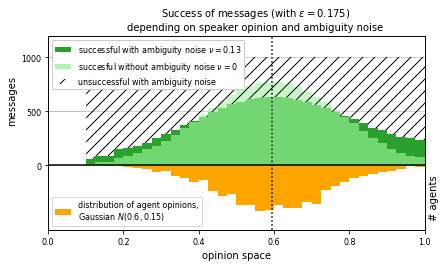

In [56]:
success_per_bin = np.array(succG)
nosuccess_per_bin = np.array(unsuccG)
success_per_bin_0Amb = np.array(succ0AmbG)

fig = plt.figure(figsize=(16/2.54,9/2.54))
ax = plt.axes()
aa, _ = np.histogram(opsG, bins=bins)
ax.bar(binmids, -aa, width=np.diff(bins)[0], label=r"distribution of agent opinions,"+"\n"+r"Gaussian $N$"+rf"$({meanG}, {sigG})$", color="orange")
ax.set_ylim(-max(aa)*1.4, max(aa)*1.4)
ax.legend(loc="lower left", fontsize=smallfs)
#ax.set_yticks([0, 10*len(ops), 20*len(ops) ])
ylim = 200
ax.set_yticks([])#[0,int(ylim/2), ylim])
#ax.set_yticklabels([int(u) for u in ax.get_yticks()])
ax.set_xlim(0,1)
ax.set_ylim(-ylim,2*ylim)
ax.yaxis.set_label_position("right")
ax.set_ylabel(r"# agents", fontsize=bigfs, y=1/6)

ax2 = ax.twinx()
a = ax2.bar(binmids, success_per_bin, color="tab:green", width=np.diff(bins)[0], label=rf"successful with ambiguity noise $\nu={nu}$")
b = ax2.bar(binmids, success_per_bin_0Amb, color="lightgreen", width=np.diff(bins)[0], label=r"succesful without ambiguity noise $\nu=0$", alpha=0.7)
c = ax2.bar(binmids, nosuccess_per_bin, bottom=success_per_bin, color="white", hatch="//", alpha=0.3, edgecolor=None, width=np.diff(bins)[0], label=r"unsuccessful with ambiguity noise")#frequency of sending"+"\n"+r"an unsuccessful message")

#d, = ax2.plot([],[], lw=0, label=fr"...with confidence bound $\epsilon={bc}$")
ax2.legend(handles=[a,b,c], loc="upper left", fontsize=smallfs, framealpha=0.99,)
ylim =1000
ax2.set_ylim(-ylim*1.2*0.5,ylim*1.2)
ax2.set_xlim(0,1)
ax2.set_yticks([0, 500, 1000])
ax2.set_yticklabels([int(l) for l in ax2.get_yticks()])
ax2.set_ylabel(r"messages", y=4/6)
ax2.grid(axis="y")
ax2.yaxis.set_ticks_position("left")
ax2.yaxis.set_label_position("left")
ax2.set_axisbelow(True)


ax.set_xlabel("opinion space", fontsize=bigfs)
ax2.vlines(np.mean(opsG), -3000,3000, color="k", linestyles=":")
ax2.hlines(0, -3000,3000, color="k")

ax.set_title(rf"Success of messages (with $\epsilon={bc}$)"+"\n"+rf"depending on speaker opinion and ambiguity noise", fontsize=bigfs, x=0.55)

plt.subplots_adjust(left=0.12, top=0.89, right=0.95, bottom=0.13)
plt.savefig(f"figs/success-in-sending_seed{s}_Gauss{meanG:.1f}-{sigG:.1f}.png", dpi=600)


## ... with uniform opinion distribution 

In [10]:

n = 300

s = 2
np.random.seed(s)

opsU = np.random.random(size=n)

nu = 0.13
bc = 0.175

successDownU = np.zeros(len(opsU))
successUpU = np.zeros(len(opsU))
unsuccesfulU = np.zeros(len(opsU))

successDown0AmbU = np.zeros(len(opsU))
successUp0AmbU= np.zeros(len(opsU))
unsuccesful0AmbU = np.zeros(len(opsU))
    
    
impact = dict(zip(range(len(opsU)), [[] for _ in range(len(opsU))]))
for speaker in range(len(opsU)):  # speaker
        for t in range(1000):
            listener, _ = np.random.choice(range(len(opsU)), size=2, replace=False)
            while True:
                m = opsU[speaker] + np.random.normal(0,nu)
                if (m <=1) and (m>=0):
                    break
            # selection
            if abs(opsU[listener] - opsU[speaker]) <= bc:
                if opsU[speaker]<=opsU[listener]:
                    successDown0AmbU[speaker]+=1
                else:
                    successUp0AmbU[speaker]+=1 
            else:                
                unsuccesful0AmbU[speaker]+=1          

                
            if abs(opsU[listener]-m) <= bc:
                impact[speaker].append((m-opsU[listener]))
                if impact[speaker][-1]>0:
                    successUpU[speaker]+=1
                else:
                    successDownU[speaker]+=1  
                #opsPost[i].append(ops[i] + 0.5 * (mAmj - ops[i]))
            else:
                unsuccesfulU[speaker]+=1  


In [11]:
# split by bins
bins = np.linspace(0,1,41)
binmids = bins[:-1]+ np.diff(bins)[0]/2

succU = []
unsuccU = []
succ0AmbU = []
unsucc0AmbU = []
#I = []
for b0, b1 in zip(bins[:-1], bins[1:]):
    inds = np.where((opsU>=b0) & (opsU<b1))[0]
    if len(inds)>0:
        succU.append(np.mean([successDownU[i]+successUpU[i] for i in inds]))
        unsuccU.append(np.mean([unsuccesfulU[i] for i in inds]))
        succ0AmbU.append(np.mean([successDown0AmbU[i] + successUp0AmbU[i] for i in inds]))
        unsucc0AmbU.append(np.mean([unsuccesful0AmbU[i] for i in inds]))
        #I.append(np.mean([np.mean(impact[i]) for i in inds]))
    else:
        succU.append(0)
        unsuccU.append(0)
        succ0AmbU.append(0)
        unsucc0AmbU.append(0)
        #I.append(0)

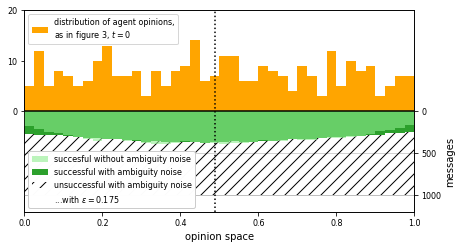

In [28]:

#succ = np.mean(succ_arr, axis=0)
#I = np.mean(I_arr, axis=0)
#unsucc = np.mean(unsucc_arr, axis=0)
#ops = np.concatenate(ops_arr)
succ = np.array(succU)
unsucc = np.array(unsuccU)
succ0Amb = np.array(succ0AmbU)

fig = plt.figure(figsize=(16/2.54,9/2.54))
ax = plt.axes()
aa, _ = np.histogram(opsU, bins=bins)
ax.hist(opsU, bins=bins, width=np.diff(bins)[0], label=r"distribution of agent opinions,"+"\n"+r"as in figure 3, $t=0$", color="orange")
ax.set_ylim(-max(aa)*1.4, max(aa)*1.4)
ax.legend(loc="upper left", fontsize=smallfs)
#ax.set_yticks([0, 10*len(ops), 20*len(ops) ])
ylim = 20
ax.set_yticks([0,int(ylim/2), ylim])
ax.set_yticklabels([int(u) for u in ax.get_yticks()])
ax.set_xlim(0,1)
ax.set_ylim(-ylim,ylim)


ax2 = ax.twinx()
a = ax2.bar(binmids, -succ, color="tab:green", width=np.diff(bins)[0], label=r"successful with ambiguity noise")
b = ax2.bar(binmids, -unsucc, bottom=-succ, color="white", hatch="//", alpha=0.3, edgecolor=None, width=np.diff(bins)[0], label=r"unsuccessful with ambiguity noise")#frequency of sending"+"\n"+r"an unsuccessful message")
d = ax2.bar(binmids, -succ0Amb, color="lightgreen", width=np.diff(bins)[0], label=r"succesful without ambiguity noise", alpha=0.6)

#c, = ax2.plot([],[], lw=0, label=fr"...with $\epsilon={bc}$ and $\nu={nu}$")
c, = ax2.plot([],[], lw=0, label=fr"...with $\epsilon={bc}$")
ax2.legend(handles=[d, a,b, c], loc="lower left", fontsize=smallfs, framealpha=0.99,)
ylim = max(succ+unsucc)
ax2.set_ylim(-ylim*1.2,ylim*1.2)
ax2.set_xlim(0,1)
ax2.set_yticks([-1000, -500, 0, ])
ax2.set_yticklabels([-int(l) for l in ax2.get_yticks()])
ax2.set_ylabel(r"messages", y=0.25)
ax2.grid(axis="y")
ax2.set_axisbelow(True)


ax.set_xlabel("opinion space", fontsize=bigfs)
ax2.vlines(np.mean(opsU), -3000,3000, color="k", linestyles=":")
ax2.hlines(0, -3000,3000, color="k")

plt.subplots_adjust(left=0.04, top=0.99, bottom=0.2)
plt.savefig(f"figs/success-in-sending_seed{s}_uniform.png", dpi=600)
